## Anomaly Detection - Compare all Models with Output

In [27]:
%reload_ext autoreload
%autoreload 2
import IPython, IPython.display, os, datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import ts_utils
import ts_plot_utils

import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.callbacks  import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Lambda, Dropout, SimpleRNN, Dense, LSTM, RepeatVector, Input, TimeDistributed, concatenate
from keras import regularizers
from keras.utils import plot_model


mpl.rcParams['figure.figsize'] = (14, 4)
mpl.rcParams['axes.grid'] = True

print(f"Tensorflow Version {tf.__version__}, Keras Vesion: {keras.__version__}")

Tensorflow Version 2.10.0, Keras Vesion: 2.10.0


## Prepare Data

In [28]:
import glob
import numpy as np

def checkFirstColumnIsTime(df ):
    if (df.columns[0] != 'time'):
        v = df.iloc[0,0]
        print("Changing the first columns to time and converting to ms", v)
        
        df.columns = ['time'] + [c for c in df.columns[1:]]
        df['time'] = pd.to_datetime(df.time).map(lambda x: int(x.timestamp()*1000) ) 
    return df

def add_perodictime(df, day=1, quarter=1, year= 1):
    day = 24*60*60
    quarter = 4 * 30 * day
    year = (365.2425)*day

    if ( 'time' in df.columns):
        timestamp_s = df['time'] / 1000  # = > get it in seconds
    else:
        timestamp_s = df.index / 1000  # = > get it in seconds

    if ( day):
        df['Day_sin']     = np.sin(timestamp_s * (2 * np.pi / day))
        df['Day_cos']     = np.cos(timestamp_s * (2 * np.pi / day))
    if ( quarter):
        df['Quarter_sin'] = np.sin(timestamp_s * (2 * np.pi / quarter))
        df['Quarter_cos'] = np.cos(timestamp_s * (2 * np.pi / quarter))
    if ( year):
        df['Year_sin']    = np.sin(timestamp_s * (2 * np.pi / year))
        df['Year_cos']    = np.cos(timestamp_s * (2 * np.pi / year))

    return df;

#Comments Othe things you may do 
'''
    => Drop highly corrlated sensors for post-mortem analysis
    => Drop time correlated sensors 
    => reduce the frequency 
    => Add periodic sensors for day, month, quarter, year
'''
def read_data(files="/tmp/test/*.csv", dropna=True ):
    li=[]
    for f in (glob.glob(files)):
        df = pd.read_csv(f, index_col=None, header=0)
        print(f"Reading {f} ...")
        li.append(df)

    df = pd.concat(li, axis=0, ignore_index=True)

    if dropna:
        df.dropna(inplace=True)
    df = df.ffill().bfill().fillna(0)    # <= we would already dropped NAs before

    df = checkFirstColumnIsTime(df)
    df.index= df['time']
    df.sort_index(inplace=True)

    df.drop('time', axis=1, inplace=True, errors="ignore")

    return df



In [3]:
import ts_transform
from ts_transform import myColumnTransformer

# Read the file
files = "/tmp/test/*SAMPLE*.csv"
df = read_data(files=files, dropna=True )
df = add_perodictime(df)
df.index = pd.to_datetime(df.index, unit='ms')

split  = int(len(df) * .7)

df1 = df
df_trn1  = df[df.columns[1:]][:split]
df_tst1  = df[df.columns[1:]][split:]

# See ts_transofrm for more details on how to use this
scaler, df_trn = myColumnTransformer.scale_df(df_trn1)
df_tst = scaler.transform(df_tst1)
df_trn.index = df_trn1.index
df_tst.index = df_tst1.index
scaler.save(os.path.dirname(files) + "/SCALER." )  # <== we can read this later if we wanted to 
df_tst

Reading /tmp/test/2022-04-30 00_00_00_2022-05-31 00_00_00_SAMPLE.csv ...
Reading /tmp/test/2022-02-28 00_00_00_2022-03-31 00_00_00_SAMPLE.csv ...
Reading /tmp/test/2022-09-30 00_00_00_2022-10-31 00_00_00_SAMPLE.csv ...
Reading /tmp/test/2022-07-31 00_00_00_2022-08-31 00_00_00_SAMPLE.csv ...
Reading /tmp/test/2022-06-30 00_00_00_2022-07-31 00_00_00_SAMPLE.csv ...
Reading /tmp/test/2022-05-31 00_00_00_2022-06-30 00_00_00_SAMPLE.csv ...
Reading /tmp/test/2022-01-31 00_00_00_2022-02-28 00_00_00_SAMPLE.csv ...
Reading /tmp/test/2022-11-30 00_00_00_2022-12-31 00_00_00_SAMPLE.csv ...
Reading /tmp/test/2022-08-31 00_00_00_2022-09-30 00_00_00_SAMPLE.csv ...
Reading /tmp/test/2022-03-31 00_00_00_2022-04-30 00_00_00_SAMPLE.csv ...
Reading /tmp/test/2022-10-31 00_00_00_2022-11-30 00_00_00_SAMPLE.csv ...
Changing the first columns to time and converting to ms 2022-04-29 12:00:00


,atime,xf,yltime,xpm,ypw,yf,pf,cs2,sl2,bf,...,cf,ypm,bl,zl,Day_sin,Day_cos,Quarter_sin,Quarter_cos,Year_sin,Year_cos
time,,,,,,,,,,,,,,,,,,,,,
2022-09-16 23:21:00,1.586989,-0.295987,1.723153,-1.281175,0.072945,-0.048786,-0.274816,-0.455619,-0.408989,-0.343625,...,-0.045186,0.072349,-0.460827,-0.453532,-0.240914,1.399703,0.558758,-1.379737,-1.868464,0.225686
2022-09-16 23:24:00,1.587058,-0.295987,1.723177,-1.281175,0.072945,-0.048786,-0.274816,-0.455619,-0.408989,-0.343625,...,-0.045186,0.072349,-0.460827,-0.453532,-0.222655,1.402720,0.558620,-1.379802,-1.868477,0.225746
2022-09-16 23:27:00,1.587128,-0.295987,1.723210,-1.281175,0.072945,-0.048786,-0.274816,-0.455619,-0.408989,-0.343625,...,-0.045186,0.072349,-0.460827,-0.453532,-0.204358,1.405497,0.558483,-1.379867,-1.868490,0.225806
2022-09-16 23:30:00,1.587197,-0.295987,1.723242,-1.281175,0.072945,-0.048786,-0.274816,-0.455619,-0.408989,-0.343625,...,-0.045186,0.072349,-0.460827,-0.453532,-0.186026,1.408034,0.558346,-1.379932,-1.868504,0.225866
2022-09-16 23:33:00,1.587266,-0.295987,1.723274,-1.281175,0.072945,-0.048786,-0.274816,-0.455619,-0.408989,-0.343625,...,-0.045186,0.072349,-0.460827,-0.453532,-0.167663,1.410331,0.558208,-1.379996,-1.868517,0.225926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22 21:45:00,3.469848,-0.295987,3.190406,0.832379,-0.162006,-0.048786,-0.274493,-0.455619,-0.408989,-0.343479,...,-0.045186,-0.172178,-0.460827,-0.347557,-0.786945,1.181722,1.372770,0.031275,-0.645193,2.359776
2022-12-22 21:48:00,3.469848,-0.295987,3.190435,0.832379,-0.162016,-0.048786,-0.274483,-0.455619,-0.408989,-0.343482,...,-0.045186,-0.172189,-0.460827,-0.347557,-0.771491,1.191909,1.372778,0.031116,-0.645140,2.359785
2022-12-22 21:51:00,3.469848,-0.295987,3.190470,0.832379,-0.162026,-0.048786,-0.274523,-0.455619,-0.408989,-0.343484,...,-0.045186,-0.172199,-0.460827,-0.347557,-0.755904,1.201892,1.372787,0.030958,-0.645087,2.359795


In [29]:
input_slice  = slice(0, len(df_trn.columns))    
label_slice  = slice(0, 20) # len(scaler.numerics))     # output columns 
window_len   = 48
ouput_len    = 1
batch_size   = 20

ouput_feat_len  = label_slice.stop - (label_slice.start or 0)
model_op_len    = ouput_feat_len * ouput_len

ds_trn = tf.data.Dataset.from_tensor_slices(df_trn[df_trn.columns[input_slice]])
ds_tst = tf.data.Dataset.from_tensor_slices(df_tst[df_tst.columns[input_slice]])
window_trn = ts_utils.window(ds_trn, window_len, ouput_len, label_slice, batch_size=batch_size, skip=0)
window_tst = ts_utils.window(ds_tst, window_len, ouput_len, label_slice, batch_size=batch_size, skip=0)
window_trn100 = ts_utils.window(ds_trn, window_len, ouput_len, label_slice, batch_size=100000, skip=0)
window_tst100 = ts_utils.window(ds_tst, window_len, ouput_len, label_slice, batch_size=100000, skip=0)

inp_feat_len    = input_slice.stop - (input_slice.start or 0)

print(f'''
    #input Features :    {len(df_trn.columns)}
    #Out Features   :    {ouput_feat_len}
    #Model outputs  :    {model_op_len}
    # Training data :    { len(ds_trn)} 
    # Testing data  :    { len(ds_tst)} 
    #Window Lenght  :    { window_len}
    #predictions    :    {ouput_len}
    #batch_size     :    {batch_size}
''')


    #input Features :    33
    #Out Features   :    20
    #Model outputs  :    20
    # Training data :    111537 
    # Testing data  :    47802 
    #Window Lenght  :    48
    #predictions    :    1
    #batch_size     :    20



## Transformer

In [2]:
import tensorflow as tf

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x):
        attn_output = self.mha( query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dr=0.1):
        super().__init__()

        self.self_attention = SelfAttention( num_heads=num_heads, key_dim=d_model, dropout=dr)
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

class Transformer(tf.keras.Model):
    def __init__(self,  d_model, windowL, target_dim, target_length=1,
                    dff= 32, num_heads=3, nLayers=6, dropout_rate=0.1):
        super().__init__()

        self.num_layers = nLayers
        self.target_length = target_length
        self.target_dim = target_dim
        self.windowL = windowL
        self.target_dim = target_dim
        
        self.l1 = tf.keras.layers.Dense(1)
        self.l2 = tf.keras.layers.Dense(d_model-1)

        self.blocks = [TransformerBlock(d_model=d_model,num_heads=num_heads,dff=dff) for _ in range(self.num_layers)]
        self.reshape = tf.keras.layers.Flatten()
        self.forecast =  tf.keras.layers.Dense(target_length*target_dim)

    def call(self,x):
        if ( type(x) == tuple):
            x = x[0]
        B,L,D = x.shape

        x1 = self.l1(x)
        x2 = tf.math.sin(self.l2(x))
        x = tf.concat([x1,x2],axis = -1)

        for i in range(self.num_layers):
            x  = self.blocks[i](x)

        x = self.reshape(x)
        x = self.forecast(x)

        #if self.target_length >= 1:
        x = tf.reshape(x,(B,self.target_length,self.target_dim))

        return x
    
    def build_graph(self):
        x = tf.keras.Input(shape=(self.windowL,self.target_dim))
        return tf.keras.Model(inputs = x,outputs = self.call(x))

2023-03-06 16:23:16.189026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
t = Transformer(d_model, window_len, ouput_feat_len, ouput_len)
model = t.build_graph()
d= plot_model(model, show_shapes=True)
display(d)

In [ ]:
# Uber Model
dim = 128

# Create Autoencoder Layer
input_layer = Input(shape=(window_len, inp_feat_len), dtype='float32', name='input')
memory_layer = LSTM(dim, return_sequences=True)(input_layer)
memory_layer = LSTM (dim//2, return_sequences=False)(memory_layer)
repeated_lyr = RepeatVector(window_len)(memory_layer)
memory_layer = LSTM (dim//2, return_sequences=True)(repeated_lyr)
memory_layer = LSTM (dim,  return_sequences=True)(memory_layer)
decoded_inputs = TimeDistributed(Dense(units=inp_feat_len, activation='linear'))( memory_layer)

dropout_input = Dropout(0.2)(input_layer)
concat_layer = concatenate([dropout_input, decoded_inputs])
memory_layer = LSTM(units=dim, 
                    kernel_regularizer = regularizers.l1_l2(l1= 0, l2= 0), 
                    recurrent_regularizer = regularizers.l1_l2(l1= 0, l2= 0), 
                    return_sequences=False)(concat_layer)

# => Note this is same as getCommonLayer(ouput_len, ouput_feat_len, memory_layer)
#
# preds = Dense(units=ouput_feat_len*ouput_len)(memory_layer)
preds = Dense(units=ouput_feat_len*ouput_len, activation='linear')(memory_layer)
preds = tf.keras.layers.Reshape([ouput_len, ouput_feat_len])(preds)
model = Model(input_layer, preds, name="Uber")

# => UNCOMMEN IF decide to do Uber model it takes long time to build this model

models.append(model)
#history = ts_utils.compile_fit(model, window_trn, window_tst, epochs=1, verbose=1)


5575/5575 [==============================] - 910s 163ms/step - loss: 0.7141 - mean_absolute_error: 0.3435 - val_loss: 0.8432 - val_mean_absolute_error: 0.4565


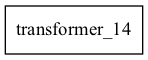

In [76]:
performace={}
models=[]

d_model = len(df_trn.columns)
input_slice # = slice(0, len(df_trn.columns))    
label_slice # = slice(0, 20) # len(scaler.numerics))     # output columns 
window_len  # = 48
ouput_len   # = 1
batch_size  # = 20
ouput_feat_len  #= label_slice.stop - (label_slice.start or 0)
model_op_len    #= ouput_feat_len * ouput_len

model = Transformer(d_model, window_len, ouput_feat_len, ouput_len)
#ts_utils.compile_fit(model, window_trn, window_tst, epochs=3, verbose=1)
#models.append(model)

callbacks = []
earlyStopCB = EarlyStopping(monitor='val_loss', patience=3, mode='min')

callbacks.append(earlyStopCB)

loss = tf.keras.losses.MeanSquaredError()
opt  = tf.keras.optimizers.Adam()
mets = [tf.keras.metrics.MeanAbsoluteError()]

model.build(input_shape=[batch_size, window_len, d_model])
model.compile(loss= loss, optimizer= opt, metrics=mets)

history = []
history = model.fit(window_trn, epochs=1, validation_data=window_tst,  callbacks=callbacks)

for x in window_trn.take(1):
    pass
x
d= plot_model(model, show_shapes=True)
display(d)


In [73]:
model(x)

<tf.Tensor: shape=(20, 20), dtype=float32, numpy=
array([[-2.6899765 ,  1.808703  , -1.151045  , -2.168316  ,  0.38556743,
        -1.0035846 , -0.24661002, -0.90938336,  1.780736  , -0.8833252 ,
         1.7686665 , -0.9587122 ,  0.2533536 ,  2.525801  , -1.1232497 ,
        -0.35780895,  1.5280306 , -0.64087987, -1.0974377 ,  1.0464952 ],
       [-2.6826053 ,  1.8094691 , -1.1390713 , -2.1763573 ,  0.38273287,
        -1.0050533 , -0.24424124, -0.9139818 ,  1.7786895 , -0.88846767,
         1.7734697 , -0.9611634 ,  0.25622064,  2.5280643 , -1.1272551 ,
        -0.3655014 ,  1.5381106 , -0.64363945, -1.0900863 ,  1.0462397 ],
       [-2.6753945 ,  1.8105978 , -1.1274433 , -2.184074  ,  0.38082618,
        -1.0062224 , -0.24148448, -0.91915864,  1.7767253 , -0.8942507 ,
         1.7780436 , -0.9632176 ,  0.25896877,  2.5296996 , -1.1312352 ,
        -0.3727123 ,  1.5478821 , -0.64637136, -1.0830538 ,  1.0461595 ],
       [-2.6676764 ,  1.8122827 , -1.1156793 , -2.192144  ,  0.3790999 

## Compile and Evaluate All Models

In [80]:
performace={}
models.append(model)

2388/2388 [==============================] - 191s 80ms/step - loss: 0.8432 - mean_absolute_error: 0.4565


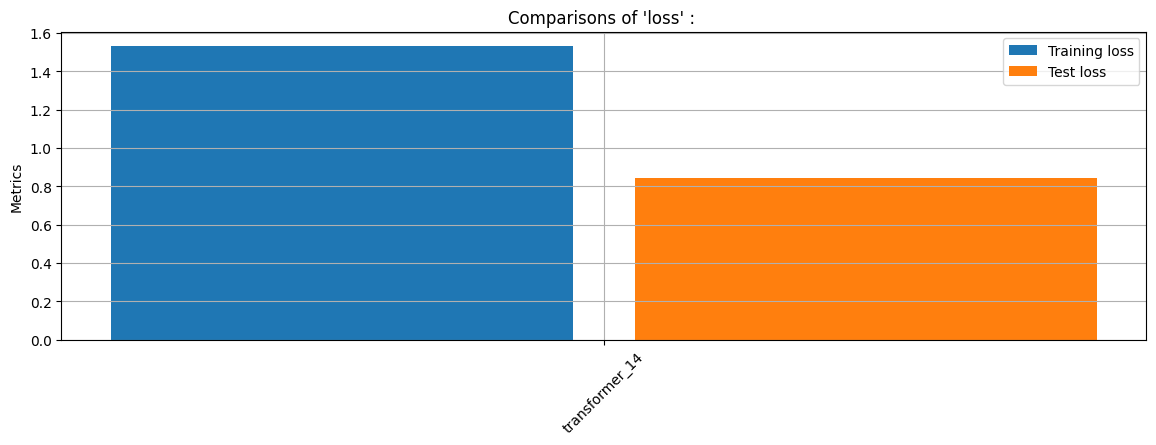

In [81]:
for i, model in enumerate(models):
    print(f"Now Compiling {i+1}/{len(models)} {model.name} ")
    #history = ts_utils.compile_fit(model, window_trn, window_tst, epochs=3, verbose=1)
    IPython.display.clear_output()

# Plot graphs
performance = ts_plot_utils.plot_performance(models, window_trn, window_tst, performance=performance)

## Model Architecture

PLotting 0 Model: transformer_14


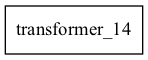

In [82]:
from keras.utils import plot_model
for i, model in enumerate(models):
    print(f"PLotting {i} Model: {model.name}")
    d= plot_model(model, show_shapes=True)
    display(d)

## Predictions

In [101]:
y.shape, yhat.shape, y.reshape((47754,20))

(TensorShape([47754, 1, 20]), TensorShape([47754, 1, 20]))

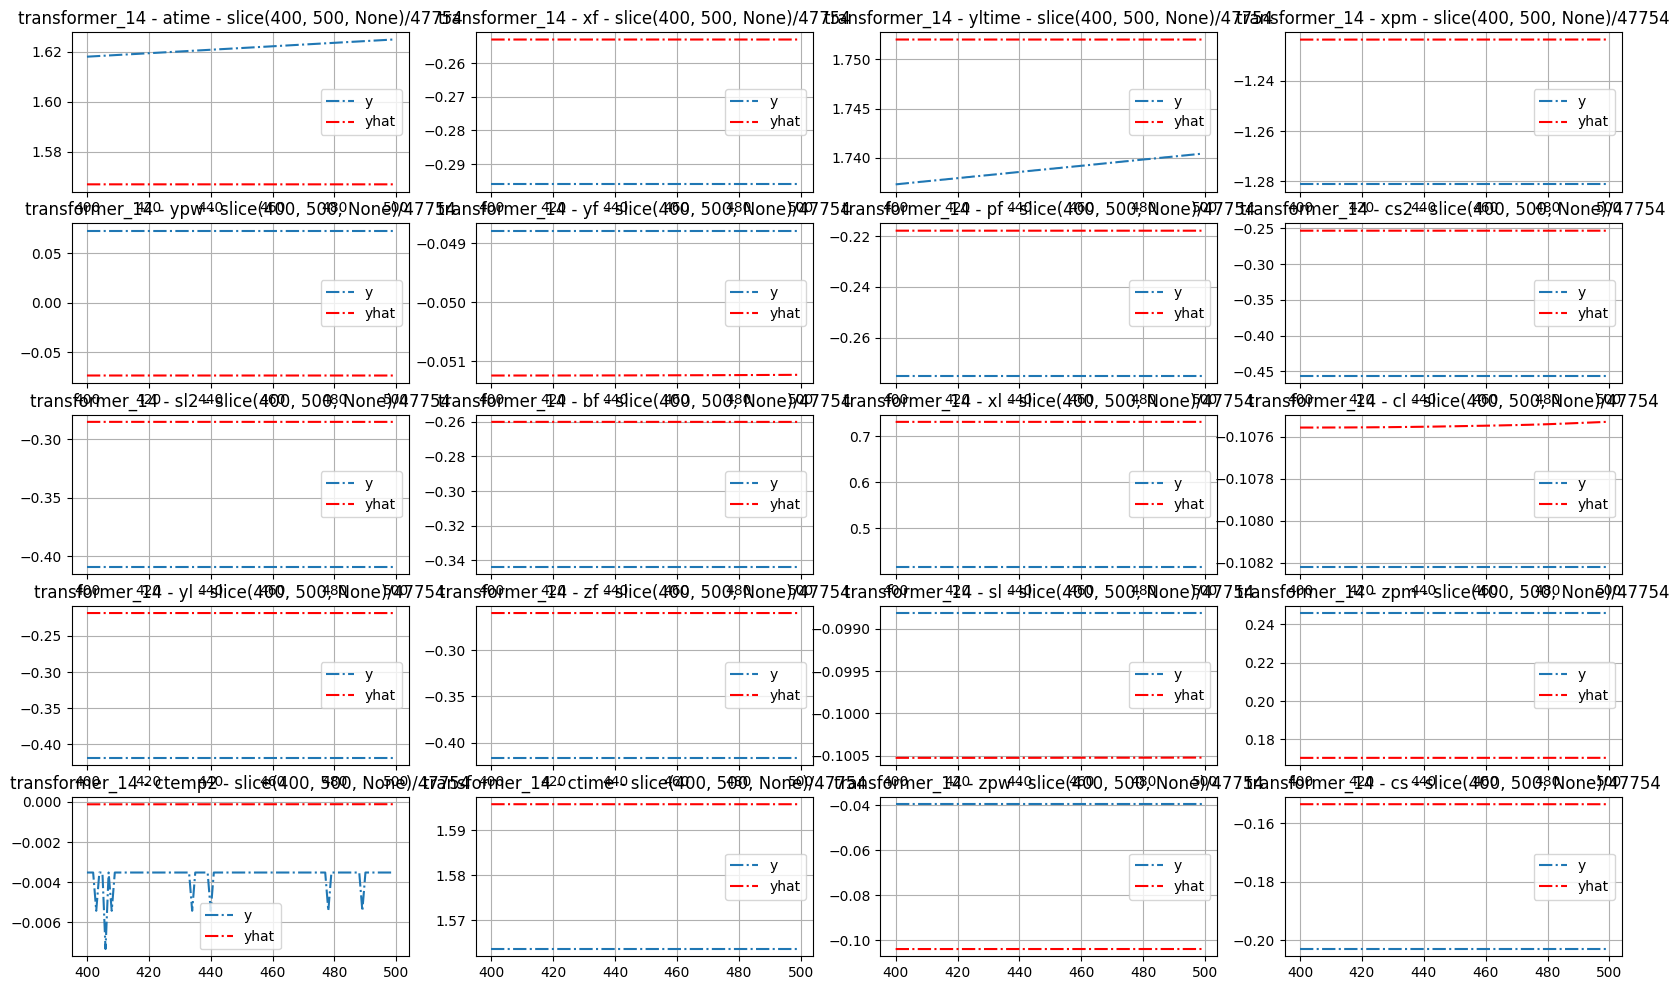

In [104]:
import matplotlib.pyplot as plt

model = models[0]
rw=slice(400, 500)
pc = 4

for x in window_tst100:
    #yp = model(x)
    #yhat = yp[:, np.newaxis, :]
    #y = x[1]
    break;
#y, yhat = ts_utils.model_predict( model , window_tst100)
#ydf = scaler.inverse_transform(pd.DataFrame(y, columns=scaler.feature_names_in_[label_slice]))
#pdf = scaler.inverse_transform(pd.DataFrame(yhat, columns=scaler.feature_names_in_[label_slice]))
'''y = y.numpy().reshape((47754,20))
yhat = yhat.numpy().reshape((47754,20))
ydf = pd.DataFrame(y, columns=scaler.feature_names_in_[label_slice])
pdf = pd.DataFrame(yhat, columns=scaler.feature_names_in_[label_slice])
'''
nc = len(ydf.columns)
pr = nc //pc
pr += 1 if len(ydf.columns)%pc else 0
fig, axs = plt.subplots(pr, pc, figsize=(20, 3 *pc))
for i, c in enumerate(ydf.columns):
    pr1 , pc1 = i // pc, i % pc
    plt1 = axs[ pr1, pc1 ]
    plt1.plot(range(len(ydf))[rw], ydf[c][rw], "-."  , label=f"y")
    plt1.plot(range(len(pdf))[rw], pdf[c][rw], "r-." , label=f"yhat")
    plt1.legend()
    plt1.set_title(f'{model.name} - {c} - {rw}/{len(ydf)}')

In [ ]:
#model = models[1]
#ydf, pdf = ts_plot_utils.predict_and_plot( model, window_trn100, window_tst100, howmany=1024* 1024,
#                        plot_start=0, df=None, scaler=None, label_slice=None);

## Anomaly graph

In [1]:
import ts_anom_utils
from ts_anom_utils import compute_scores

y, yhat = ts_utils.model_predict( model , window_trn100)
ydf = scaler.inverse_transform(pd.DataFrame(y, columns=scaler.feature_names_in_[label_slice]))
pdf = scaler.inverse_transform(pd.DataFrame(yhat, columns=scaler.feature_names_in_[label_slice]))

ret, error, se, errorDF, escaler, fscore = compute_scores(ydf, pdf, errorDF= None, escaler=None)

y, yhat = ts_utils.model_predict( model , window_tst100)
ydf = scaler.inverse_transform(pd.DataFrame(y, columns=scaler.feature_names_in_[label_slice]))
pdf = scaler.inverse_transform(pd.DataFrame(yhat, columns=scaler.feature_names_in_[label_slice]))

ret, error, se, errorDF, escaler, fscore = compute_scores(ydf, pdf, errorDF, escaler, fscore=fscore )

errorDF

NameError: name 'ts_utils' is not defined

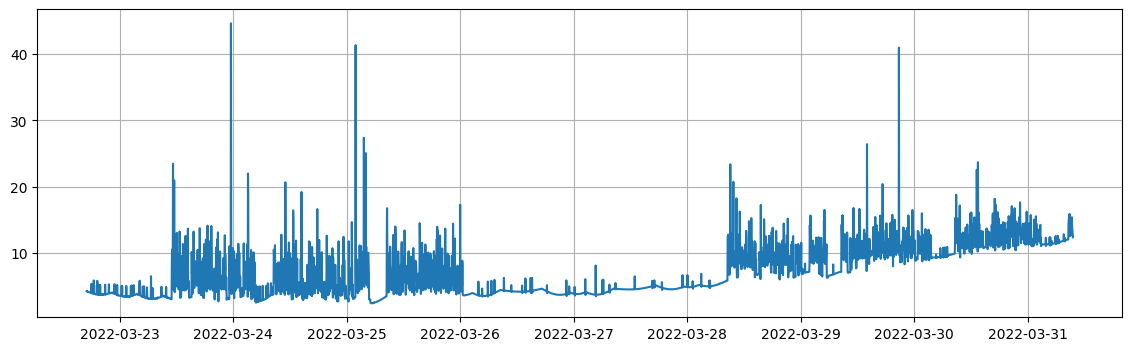

In [ ]:
plt.plot(pd.to_datetime(df_tst.index, unit='ms')[0:len(ret)], ret.norm_score)

### The END